# Electromyography (EMG) signal processing

In this Jupyter notebook we will be analyzing an EMG data example. The EMG dataset consists of an isometric contraction (i.e., a contraction in which the muscle does not change its length) of the biceps muscles (i.e., the large muscle that lies on the front of your upper arm) with a 40 lb bar. The subject was asked to carry the bar with their arms flexed at 90 degrees until they could not carry the weight any more. The data were acquired using a Delsys EMG Trigno System with the Delsys EMG acquisition software. Data were acquired at 1500 Hz sampling rate.

## Import libraries
First, we will import the necessary libraries to read and analyze the [EMG data](emg_data.csv).

In [1]:
## Import libraries
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, detrend, iirnotch, find_peaks, filtfilt


## Import data
Usually, we will use a software from the instrumentation manufacturer to acquire the data that we will process. Commonly, this software will have a data analysis software companion, or the data can be exported to other formats. In this example, we will import the [emg_data.csv](emg_data.csv) file to be further processed. There are two EMG channels in this data set. The first column is the time vector, and the second and third columns are the EMG signals of the right and left biceps brachii. For this example, we will use the data from the **right biceps brachii**.

In [8]:
# Settings
file_name = "emg_data.csv"
srate = 1500    # Sampling rate [Hz]

# Import data and visualize the first 5 rows
data = pd.read_csv(file_name)
print(data.head())

# Extract the EMG data
time = data["time"].to_numpy()
raw_emg = data["right_biceps"].to_numpy()

       time  left_biceps  right_biceps
0  0.000000     0.000114     -0.000019
1  0.000667    -0.001259     -0.000748
2  0.001333    -0.001356     -0.001491
3  0.002000     0.000594     -0.000369
4  0.002667    -0.000210      0.000169


## Pre-processing

### Detrend data
Recordings of biological signals might have a drift due to the sensors being used. In the case of EMG and EEG, this drift is caused by a DC potential at the electrode-skin interface.To remove this drift we can use the detrend function to remove the best straight-fit line from the signal. The following code can be used to detrend the data.

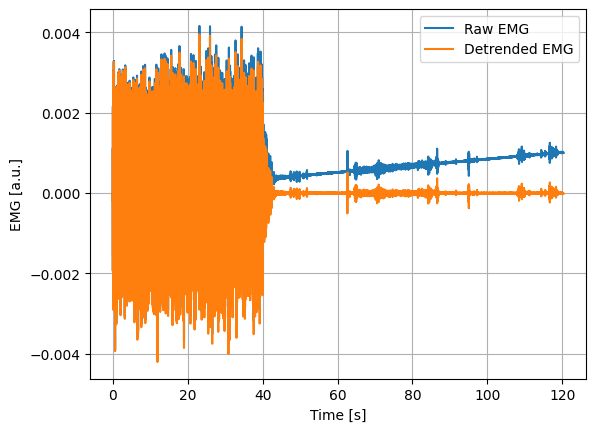

In [11]:
detrended_emg = detrend(raw_emg)

# Plot the raw and detrended EMG data
plt.figure()
plt.plot(time, raw_emg, label="Raw EMG")
plt.plot(time, detrended_emg, label="Detrended EMG")
plt.xlabel("Time [s]")
plt.ylabel("EMG [a.u.]")
plt.legend()
plt.grid(True)  # Add grid
plt.show()

### Filter data
Once the data has been detrended, we want to get rid of any signals that are not of interest. For example, with the EMG data, we are interested in frequencies between 10 - 250 Hz. Thus, we will implement a 6th order Butterworth bandpass filter to get rid of noise outside of this frequency range.

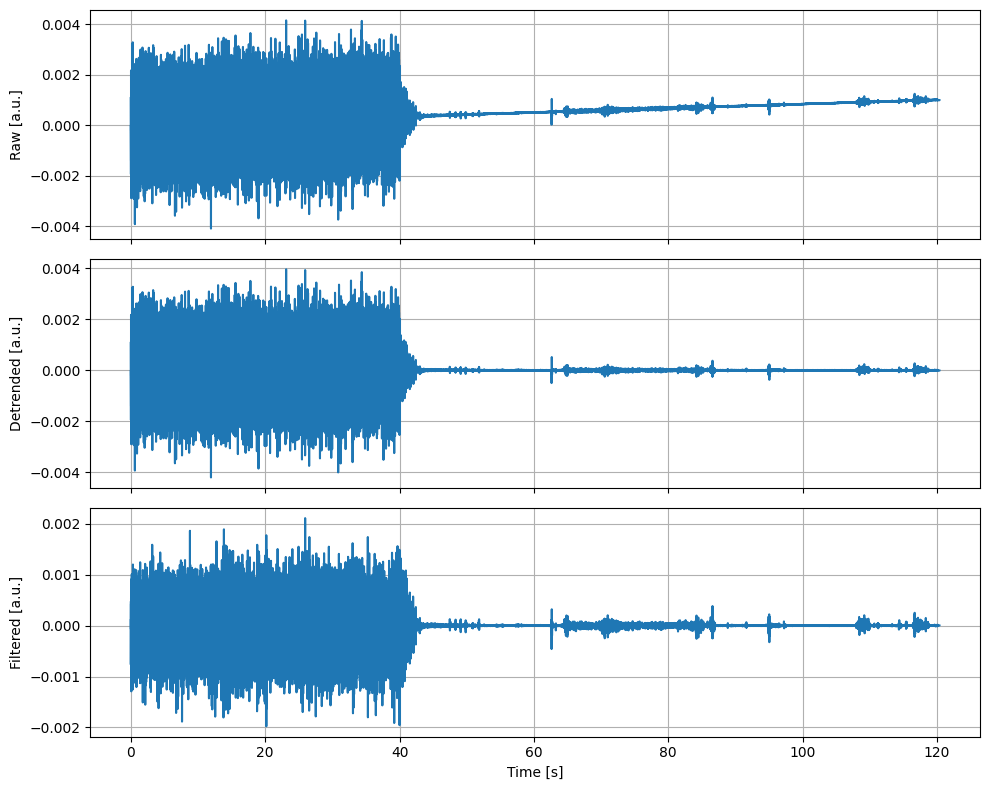

In [18]:
## Settings
fc = [10, 250]  # Cutoff frequency [Hz]
order = 4       # Filter order

# Create a band-pass Butterworth filter
sos = butter(order, fc, btype="band", fs=srate, output="sos")

# Apply the filter to the EMG data
filtered_emg = sosfiltfilt(sos, detrended_emg)

# Plot the raw, detrended, and filtered EMG data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax1.plot(time, raw_emg)
ax1.set_ylabel("Raw [a.u.]")
ax1.grid(True)

ax2.plot(time, detrended_emg)
ax2.set_ylabel("Detrended [a.u.]")
ax2.grid(True)

ax3.plot(time, filtered_emg)
ax3.set_ylabel("Filtered [a.u.]")
ax3.set_xlabel("Time [s]")
ax3.grid(True)

plt.tight_layout()
plt.show()


### Trim the data
After importing the data we might want to partition it into sections that are useful for analysis. For example, if we start recording a few seconds before the experiment begins, or the experiment is shorter than the recording time, we would want to trim the data. Additionally, we could have triggers related to the experiment to know the start and end times of the signal of interest. 

In the provided dataset we do not have external triggers; here we would like to trim the data to 35 seconds after the recording started. This is when the subject let go of the weight due to fatigue. This can be visualized as the amplitude of the EMG signal changes abruptly after 40 seconds into the recording. We will also trim the time vector to match the length of the data after partitioning.

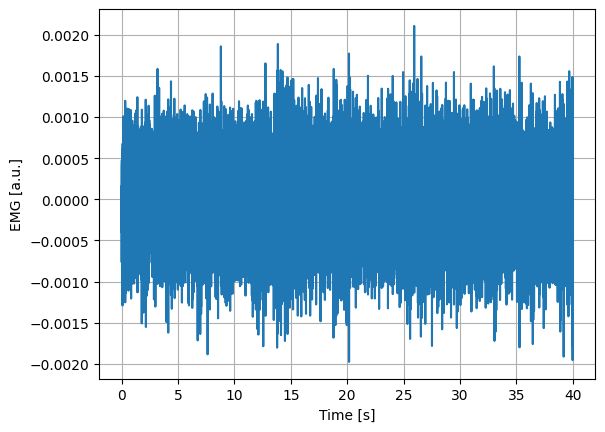

In [19]:
## Settings
trim_time = 40  # Time to trim from the beginning and end of the signal [s]

# Trim the signal
trimmed_time = time[0:trim_time*srate]
trimmed_emg = filtered_emg[0:trim_time*srate]

# Plot the trimmed data
plt.figure()
plt.plot(trimmed_time, trimmed_emg)
plt.xlabel("Time [s]")
plt.ylabel("EMG [a.u.]")
plt.grid(True)

## Processing

### Frequency analysis
The second type of analysis we will perform is a frequency domain analysis to look at the signal power spectrum. We will use the pwelch function to calculate the power spectrum of the filtered signal. As a reminder, from the Nyquist-Shannon sampling theorem, the highest frequency we can see in the power spectrum is half of the sampling frequency.The frequency resolution can be calculated with the following formula:

Where  is the sampling frequency or rate of the signal, and  is the number of samples used for the FFT. We will compute the power spectrum of the trimmed and filtered signals to look at the effect the filter had on the data